비지도학습(Unspuevised Learning)은 종속변수가 주어지지 않은 상태에서 학습을 수행하는 방식이다.

K-means Algorithm

군집화(clustering)는 데이터를 여러개의 군집으로 구성해 데이터 간의 관계를 분석하고 이에 따라 유사한 데이터 군집으로 구성하는 방법이다.

K-평균 알고리즘(K-means algorithm)은 주어진 데이터를 k개의 군집(cluster)로 나누기 위한 알고리즘이다.

k개의 중심점을 임의의 위치로 잡고 중심점을 기준으로 가까이 있는 데이터를 확인한 뒤 그들과의 (유클리디안)거리의 평균 지점을 새로운 k개의 중심점으로 지정한다. 

이 과정을 더이상 k개의 중심점이 이동하지 않을 때까지 반복하게 되면 최종적으로 k개의 중심점과 각 중심점에서 거리가 가까운 데이터들이 모인 k개의 군집이 생성된다.

In [1]:
from IPython.display import Image

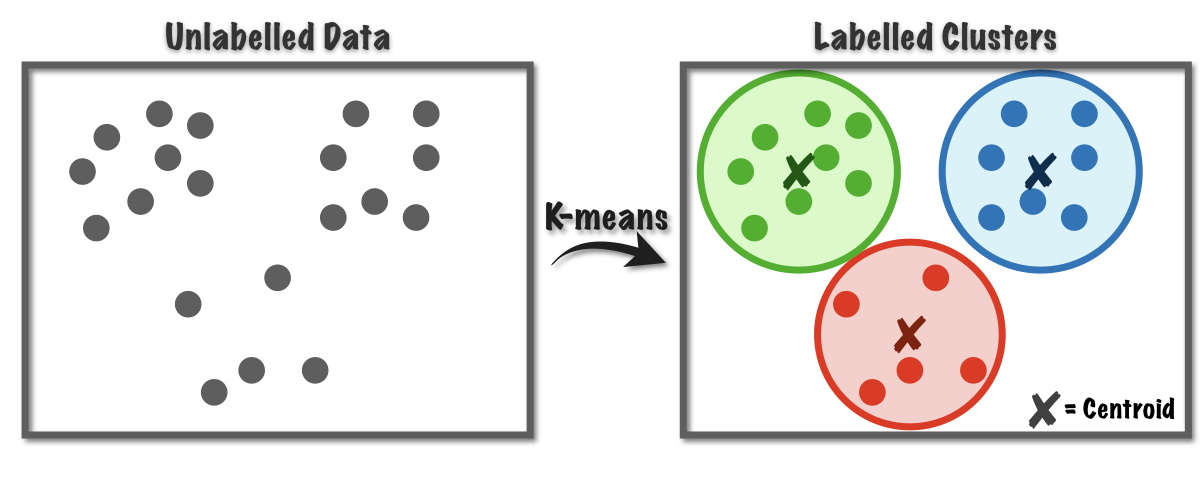

In [2]:
Image("C:/Users/juhyj/Desktop/kmeans.png", width = 600, height = 300)

이때, 가장 적합한 군집의 수 k를 직접 지정해야 하는 문제가 있다. 

가장 많이 사용하는 방법으로는 엘보 방법(elbow method)가 있다. 이 방법은 k개의 중심점과 각 중심점에서 거리가 가까운 데이터들의 차이의 제곱 합을 사용한다. 이 값을 왜곡(distortion)이라고 하는데 k값은 변화에 따른 왜곡 그래프를 그려보면 그래프가 꺽이는 지점인 엘보를 확인할 수 있고, 그 위치의 k값을 군집의 수로 사용하게 된다.

또 다른 방법으로 실루엣 분석(silhouette analysis)을 사용한다. 이는 같은 군집 내에 있는 데이터가 얼마나 조밀하게 모여있는지를 측정하는 그래프 도구이다. 실루엣 계수는 -1에서 1 사이의 값을 가지며 1에 가까울수록 좋은 군집화를 의미한다.

또한, 우리는 k개의 각 군집을 수리적으로 처리해 나누어 놓았기 때문에, 각 군집의 데이터의 특성을 이용해 군집에 대한 명명(lable)을 해 주어야 한다.

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
retail_df = pd.read_excel('C:/Users/juhyj/Desktop/OnlineRetail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Quantity 값이 0 또는 음수인 것 제거
retail_df = retail_df[retail_df['Quantity']>0]
# UnitPrice 값이 0 또는 음수인 것 제거
retail_df = retail_df[retail_df['UnitPrice']>0]
# CustomerID가 없는 자료는 사용할 수 없으므로, 값이 있는 406,829개를 제외한 나머지 데이터 제거.
retail_df = retail_df[retail_df['CustomerID'].notnull()]
# CustomerID 자료형을 실수(flot64)에서 정수 형태로 변환(int)
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)
# 중복 기록 제거
retail_df.drop_duplicates(inplace = True)
print('데이터셋 크기: ',retail_df.shape)
retail_df.info()

데이터셋 크기:  (392692, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int32         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 25.5+ MB


In [6]:
# 제품 수, 거래 건수, 고객 수 확인
pd.DataFrame([{'Product' : len(retail_df['StockCode'].value_counts()),
               'Transaction' : len(retail_df['InvoiceNo'].value_counts()),
               'Customer' : len(retail_df['CustomerID'].value_counts())}],
               columns = ['Product', 'Transaction', 'Customer'], index = ['counts'])

,Product,Transaction,Customer
counts,3665,18532,4338


In [7]:
# 국적별 고객 수 확인
pd.DataFrame(retail_df['Country'].value_counts())

,Country
United Kingdom,349203
Germany,9025
France,8326
EIRE,7226
Spain,2479
Netherlands,2359
Belgium,2031
Switzerland,1841
Portugal,1453
Australia,1181


In [8]:
# 주문 금액 변수 추가
retail_df['SaleAmount'] = retail_df['UnitPrice']*retail_df['Quantity']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [9]:
# 고객(CustomerID) 기준으로 병합
aggregations = {
    
    'InvoiceNo' : 'count', # 주문 회수
    'SaleAmount' : 'sum', # 구매 금액 합산
    'InvoiceDate' : 'max' # 가장 최근 주문 날짜
}

customer_df = retail_df.groupby('CustomerID').agg(aggregations)
customer_df.head()

,InvoiceNo,SaleAmount,InvoiceDate
CustomerID,,,
12346,1,77183.60,2011-01-18 10:01:00
12347,182,4310.00,2011-12-07 15:52:00
12348,31,1797.24,2011-09-25 13:13:00
12349,73,1757.55,2011-11-21 09:51:00
12350,17,334.40,2011-02-02 16:01:00


In [10]:
customer_df = customer_df.reset_index() # index 리셋
customer_df.head()

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


In [11]:
# 가장최근 주문 날짜를 기준으로 현 시점(여기서는 2011년 12월 10일)까지 얼마나 지났는지 계산
import datetime

customer_df['InvoiceDate'] = datetime.datetime(2011,12,10) - customer_df['InvoiceDate']
customer_df.head()

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,325 days 13:59:00
1,12347,182,4310.00,2 days 08:08:00
2,12348,31,1797.24,75 days 10:47:00
3,12349,73,1757.55,18 days 14:09:00
4,12350,17,334.40,310 days 07:59:00


In [12]:
# 날짜만 남기고 삭제
customer_df['InvoiceDate'] = customer_df['InvoiceDate'].apply(lambda x: x.days+1)
customer_df.head()

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,326
1,12347,182,4310.00,3
2,12348,31,1797.24,76
3,12349,73,1757.55,19
4,12350,17,334.40,311


In [13]:
# 변수명 변경
customer_df = customer_df.rename(columns = {'InvoiceNo' : 'Freq', 'InvoiceDate':'ElapsedDays'})
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,326
1,12347,182,4310.00,3
2,12348,31,1797.24,76
3,12349,73,1757.55,19
4,12350,17,334.40,311


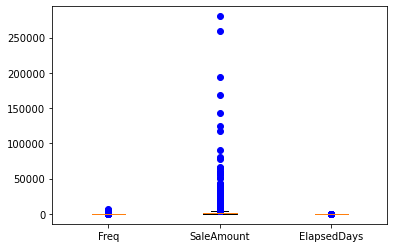

In [14]:
# 데이터 값이 한쪽으로 치중되어 있는지 확인
import seaborn as sns

fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']], sym = 'bo') 
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount', 'ElapsedDays'])
plt.show()

In [15]:
# sym = 'bo' (box-plot)옵션을 통해 파란색 점으로 표시가 많이 나타나면 아웃라이어 값(치우쳐진 값)이 표시되는데
# plot을 보면 데이터가 고르게 분포되어 있지 않음을 확인할 수 있다.
# 이러한 경우 분석 결과가 정확하다고 할 수 없으므로, 로그 함수를 적용하여 값의 분포를 고르게 조정한다.

customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,1,77183.60,326,0.693147,11.253955,5.789960
1,12347,182,4310.00,3,5.209486,8.368925,1.386294
2,12348,31,1797.24,76,3.465736,7.494564,4.343805
3,12349,73,1757.55,19,4.304065,7.472245,2.995732
4,12350,17,334.40,311,2.890372,5.815324,5.743003


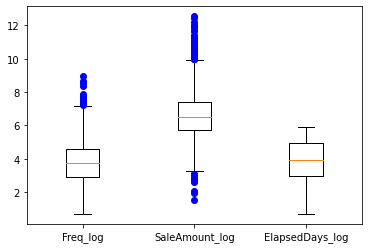

In [16]:
fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq_log'], customer_df['SaleAmount_log'], customer_df['ElapsedDays_log']], sym = 'bo') 
plt.xticks([1, 2, 3], ['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'])
plt.show()

In [17]:
# 분석에 사용할 값을 정규 분포로 스케일링
from sklearn.cluster import KMeans # K-Means
from sklearn.metrics import silhouette_score, silhouette_samples # 실루엣 계수 계산
from sklearn.preprocessing import StandardScaler

X_features = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

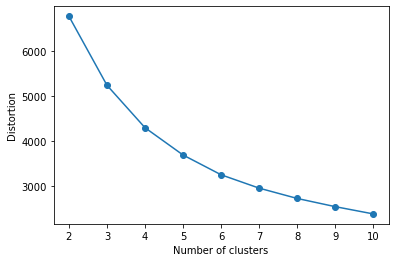

In [18]:
# 엘보 방법으로 클러스터 개수 k 선택
distortions = []

for i in range(2,11):
    kmeans_i = KMeans(n_clusters = i, random_state = 0) # 모형 생성
    kmeans_i.fit(X_features_scaled) # 모형 훈련
    distortions.append(kmeans_i.inertia_)
    
plt.plot(range(2,11), distortions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [19]:
# 실루엣 계수에 따른 각 군집의 비중 시각화 함수 정의
from matplotlib import cm

def silhouetteViz(n_cluster, X_features): 
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)
    
    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)
    
    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster : '+ str(n_cluster)+'\n' \
              + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))   
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

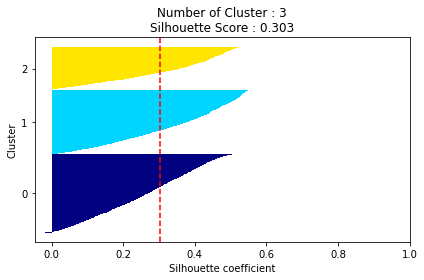

In [20]:
# k = 3
silhouetteViz(3, X_features_scaled)

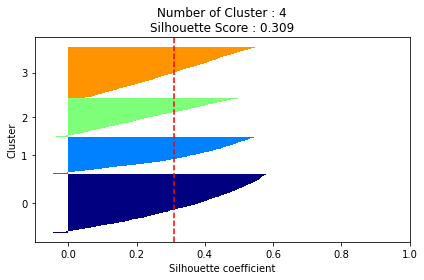

In [21]:
# k = 4
silhouetteViz(4, X_features_scaled)

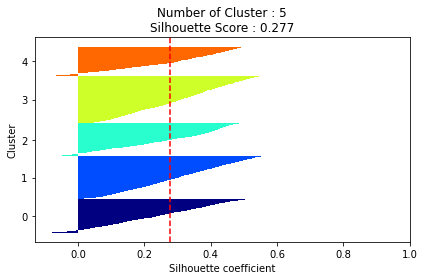

In [22]:
# k = 5
silhouetteViz(5, X_features_scaled)

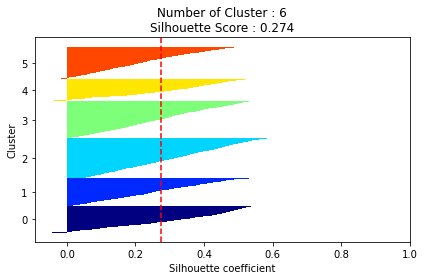

In [23]:
# k = 6
silhouetteViz(6, X_features_scaled)

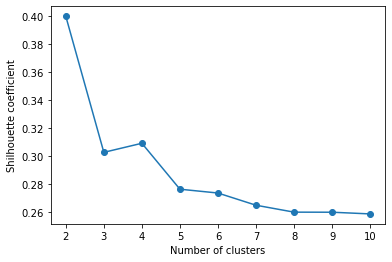

In [24]:
silhouette = []

for i in range(2,11):
    kmeans_i = KMeans(n_clusters = i, random_state = 0) # 모형 생성
    kmeans_i.fit(X_features_scaled) # 모형 훈련
    silhouette_values = silhouette_score(X_features_scaled, kmeans_i.labels_)
    silhouette.append(silhouette_values)
    
plt.plot(range(2,11), silhouette, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Shilhouette coefficient')
plt.show()

In [25]:
# 군집 수에 따른 군집 데이터 분포의 시각화 함수 정의

def clusterScatter(n_cluster, X_features): 
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) #클러스터의 색상 설정
        c_colors.append(c_color)
        #클러스터의 데이터 분포를 동그라미로 시각화
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1],
                     marker='o', color=c_color, edgecolor='black', s=50, 
                     label='cluster '+ str(i))       
    
    #각 클러스터의 중심점을 삼각형으로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], 
                    marker='^', color=c_colors[i], edgecolor='w', s=200)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

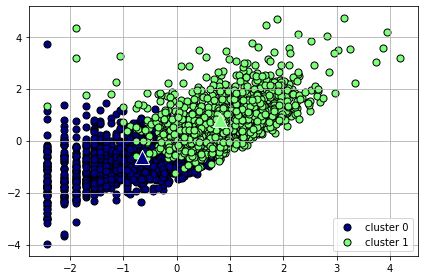

In [26]:
# k = 2
clusterScatter(2, X_features_scaled)

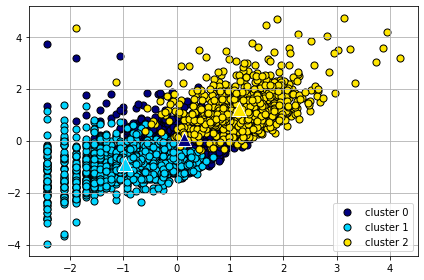

In [27]:
# k = 3
clusterScatter(3, X_features_scaled)

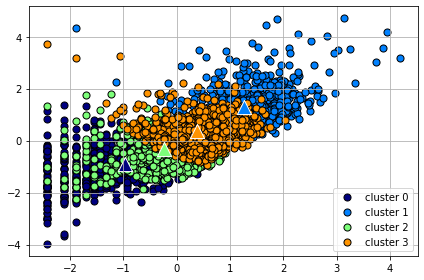

In [28]:
# k = 4
clusterScatter(4, X_features_scaled)

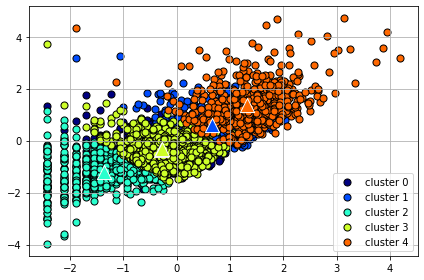

In [29]:
# k = 5
clusterScatter(5, X_features_scaled)

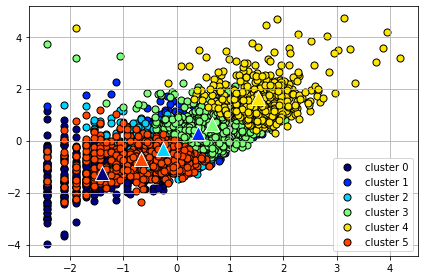

In [30]:
# k = 6
clusterScatter(6, X_features_scaled)

실루엣 계수가 가장 높은 값은 군집 4개에서 0.309이 나왔고, 군집 분포를 통해 확인해본 결과 역시 군집 4개인 경우 가장 군집끼리 잘 모여있는 형태로 나타나있다. 엘보 방법도 군집 4개 지점을 선택하는 것이 적당해 보인다. 이런 내용을 종합해 최적의 군집 수 k는 4로 결정할 수 있다.

In [31]:
# k = 4 으로 선택하고 진행
best_cluster = 4
kmeans = KMeans(n_clusters = best_cluster, random_state = 0)
Y_labels = kmeans.fit_predict(X_features_scaled)
customer_df['ClusterLabel'] = Y_labels
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,3
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,3
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,3
4,12350,17,334.40,311,2.890372,5.815324,5.743003,0


In [32]:
# 각 군집 별 고객 수 확인
customer_df.groupby('ClusterLabel')['CustomerID'].count()

ClusterLabel
0    1370
1     868
2     893
3    1207
Name: CustomerID, dtype: int64

In [33]:
# 모형 구축에 사용된 로그 변수 제거
customer_cluster_df = customer_df.drop(['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'], axis = 1, inplace = False)
# 고객별 1회당 평균 구매 금액 계산: SaleAmountAvg
customer_cluster_df['SaleAmountAvg'] = customer_cluster_df['SaleAmount']/customer_cluster_df['Freq']
customer_cluster_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,ClusterLabel,SaleAmountAvg
0,12346,1,77183.60,326,3,77183.600000
1,12347,182,4310.00,3,1,23.681319
2,12348,31,1797.24,76,3,57.975484
3,12349,73,1757.55,19,3,24.076027
4,12350,17,334.40,311,0,19.670588


In [34]:
cluster_df = customer_cluster_df.drop(['CustomerID'], axis = 1, inplace = False)
cluster_df = cluster_df.groupby('ClusterLabel').mean()
cluster_df

,Freq,SaleAmount,ElapsedDays,SaleAmountAvg
ClusterLabel,,,,
0,15.100000,298.966147,188.241606,43.290636
1,279.207373,7031.952834,13.479263,96.921011
2,37.793953,603.425354,20.959686,32.226856
3,79.455675,1520.324252,95.595692,103.086284
